# BitCoin Ransom Ware Detection: Predictive Modeling

### Downloading the dataset & setting CSV

In [1]:
#!wget https://archive.ics.uci.edu/static/public/526/bitcoinheistransomwareaddressdataset.zip

#from zipfile import ZipFile

#with ZipFile("bitcoinheistransomwareaddressdataset.zip",'r') as zObject:
    #zObject.extractall(path = '')

# Preliminary data Analysis

In [2]:
import numpy as np
import pandas as pd
bit=pd.read_csv('BitcoinHeistData.csv')
print(f'{bit.shape}\n{bit.size}')

(2916697, 10)
29166970


Loop : intended to count how many transaction i) split their coins; ii) move these coins in the network by using different paths and finally, and iii) merge them in a single address. Coins at this final address can then be sold and converted to fiat currency

Weight: quantifies the merge behavior (i.e., the transaction has more input addresses than output addresses), where coins in multiple addresses are each passed through a succession of merging transactions and accumulated in a final address

Count: designed to quantify the merging pattern
count feature represents information on the number of transactions, whereas the weight feature represents information on the amount (what percent of the transactions output) of transactions.

Length: designed to quantify mixing rounds on Bitcoin, where transactions receive and distribute similar amounts of coins in multiple rounds with newly created addresses to hide the coin origin.

When compared to non-ransomware addresses, ransomware addresses exhibit more profound right skewness in distributions of feature values.

In [3]:
bit.head()

,address,year,day,length,weight,count,looped,neighbors,income,label
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,100050000.0,princetonCerber
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,100000000.0,princetonLocky
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000,1,0,2,200000000.0,princetonCerber
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.003906,1,0,2,71200000.0,princetonCerber
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,200000000.0,princetonLocky


In [4]:
bit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916697 entries, 0 to 2916696
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   address    object 
 1   year       int64  
 2   day        int64  
 3   length     int64  
 4   weight     float64
 5   count      int64  
 6   looped     int64  
 7   neighbors  int64  
 8   income     float64
 9   label      object 
dtypes: float64(2), int64(6), object(2)
memory usage: 222.5+ MB


In [5]:
bit.shape

(2916697, 10)

In [6]:
# Indentifies all the unique values within our columns
for col in bit:
    print(f'{col}: {bit[col].unique()}\n')

address: ['111K8kZAEnJg245r2cM6y9zgJGHZtJPy6' '1123pJv8jzeFQaCV4w644pzQJzVWay2zcA'
 '112536im7hy6wtKbpH1qYDWtTyMRAcA2p7' ...
 '1P7PputTcVkhXBmXBvSD9MJ3UYPsiou1u2' '15iPUJsRNZQZHmZZVwmQ63srsmughCXV4a'
 '3LFFBxp15h9KSFtaw55np8eP5fv6kdK17e']

year: [2017 2016 2013 2014 2015 2012 2011 2018]

day: [ 11 132 246 322 238  96 225 324 298  62 317 247 146   3 158 156 273  56
 165 109  79 127  21 250 155  65  81  46 330 256 218  52 289 266 348  89
  85  68 316  49  51 336 137  47  88 106 198 321  35 178 279 125  80 120
  84 126 103  75 111   2 182 168 163 160 161 162 141 139 135 133 138 136
 108  53 223  74 116  32  55 339  57 319 338 269 260 274 285 286  86 280
 112 229  83 195  76  72  73  77  71  78 249 236 128 175 356 123 113 337
 320 315   7  63 288 208 189 318 124 159  27  60  99  54 145 134 311 226
 140 248 284 340 157  44 143  70  67 295 210 333  61 312 261  38  10 291
  17 310  26 362 355 363 325  31  14 352 275 360  41 282 349 345 335 263
 326  40 314 331 276 332 309   8  12 358 313  39 

## Data Tidying & Recatorgization

In [7]:
# Creates month variable to identify when these transactions occur
bit['month'] = pd.to_datetime(bit['day'], format = '%j').dt.month_name()
bit['month'] = bit['month'].astype('category')

# Changes year variable to a categorical one
bit['year'] = bit['year'].astype('category')

# Drops the Day variable, as we now have a month variable which is better suited for our needs
bit.drop('day', axis = 1, inplace = True)

# Groups all the ransomware labels under one group
bit.loc[bit['label'] != 'white', 'label'] = 'ransom'

# Drops address variable, as it provides nothing
bit.drop('address', axis=1, inplace=True)

# Regroups the label bittype as a category rather than an object
bit['label'] = bit['label'].astype('category')

# Changes the income variable from Satoshi currency to Bitcoin Currency
# Where 1 BitCoin = 100 million Satoshi's
bit['income'] = bit['income'] / 10**8

In [8]:
bit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916697 entries, 0 to 2916696
Data columns (total 9 columns):
 #   Column     Dtype   
---  ------     -----   
 0   year       category
 1   length     int64   
 2   weight     float64 
 3   count      int64   
 4   looped     int64   
 5   neighbors  int64   
 6   income     float64 
 7   label      category
 8   month      category
dtypes: category(3), float64(2), int64(4)
memory usage: 141.9 MB


In [9]:
bit['label'].value_counts()

label
white     2875284
ransom      41413
Name: count, dtype: int64

In [11]:
ransom_count = bit['label'].value_counts()['ransom']

# Calculate the number of 'white' values to keep to match the count of 'ransom' values
target_count = ransom_count

# Sample the 'white' values to match the count of 'ransom' values
sampled_white = bit[bit['label'] == 'white'].sample(n=target_count, replace=False)

# Combine the sampled 'white' values and the 'ransom' values
bit = pd.concat([sampled_white, bit[bit['label'] == 'ransom']])

# Shuffle the rows of the balanced dataFrame
bit = bit.sample(frac=1).reset_index(drop=True)

# Now contains a similar count of 'white' and 'ransom' values
print(bit['label'].value_counts())

label
ransom    41413
white     41413
Name: count, dtype: int64


## Performing One-Hot Encoding On Categorical Variables

In [12]:
print('Duplicated Count for dataset:')
print(bit.duplicated().sum())
bit.drop_duplicates(inplace=True, ignore_index=True)

Duplicated Count for dataset:
5945


In [13]:
bit.info()
print('\nNull Count for dataset:')
print(bit.isnull().sum())
print('\nDuplicated Count for dataset:')
print(bit.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76881 entries, 0 to 76880
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   year       76881 non-null  category
 1   length     76881 non-null  int64   
 2   weight     76881 non-null  float64 
 3   count      76881 non-null  int64   
 4   looped     76881 non-null  int64   
 5   neighbors  76881 non-null  int64   
 6   income     76881 non-null  float64 
 7   label      76881 non-null  category
 8   month      76881 non-null  category
dtypes: category(3), float64(2), int64(4)
memory usage: 3.7 MB

Null Count for dataset:
year         0
length       0
weight       0
count        0
looped       0
neighbors    0
income       0
label        0
month        0
dtype: int64

Duplicated Count for dataset:
0


In [14]:
bit = pd.get_dummies(bit, columns=["label","year","month"], drop_first=True)

In [15]:
bit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76881 entries, 0 to 76880
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   length           76881 non-null  int64  
 1   weight           76881 non-null  float64
 2   count            76881 non-null  int64  
 3   looped           76881 non-null  int64  
 4   neighbors        76881 non-null  int64  
 5   income           76881 non-null  float64
 6   label_white      76881 non-null  bool   
 7   year_2012        76881 non-null  bool   
 8   year_2013        76881 non-null  bool   
 9   year_2014        76881 non-null  bool   
 10  year_2015        76881 non-null  bool   
 11  year_2016        76881 non-null  bool   
 12  year_2017        76881 non-null  bool   
 13  year_2018        76881 non-null  bool   
 14  month_August     76881 non-null  bool   
 15  month_December   76881 non-null  bool   
 16  month_February   76881 non-null  bool   
 17  month_Januar

In [16]:
bit.head()

,length,weight,count,looped,neighbors,income,label_white,year_2012,year_2013,year_2014,...,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,70,0.677464,22,12,2,0.7805,True,True,False,False,...,False,False,False,False,False,False,False,True,False,False
1,2,0.500000,1,0,2,5.0000,True,False,True,False,...,False,False,False,False,False,True,False,False,False,False
2,8,0.218750,3,0,2,1.0000,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,98,0.247221,157,0,2,0.9500,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,16,0.003906,1,1,2,32.5700,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [17]:
print(f'Data Shape: {bit.shape}\nData Size: {bit.size}')

Data Shape: (76881, 25)
Data Size: 1922025


## Data Visualization

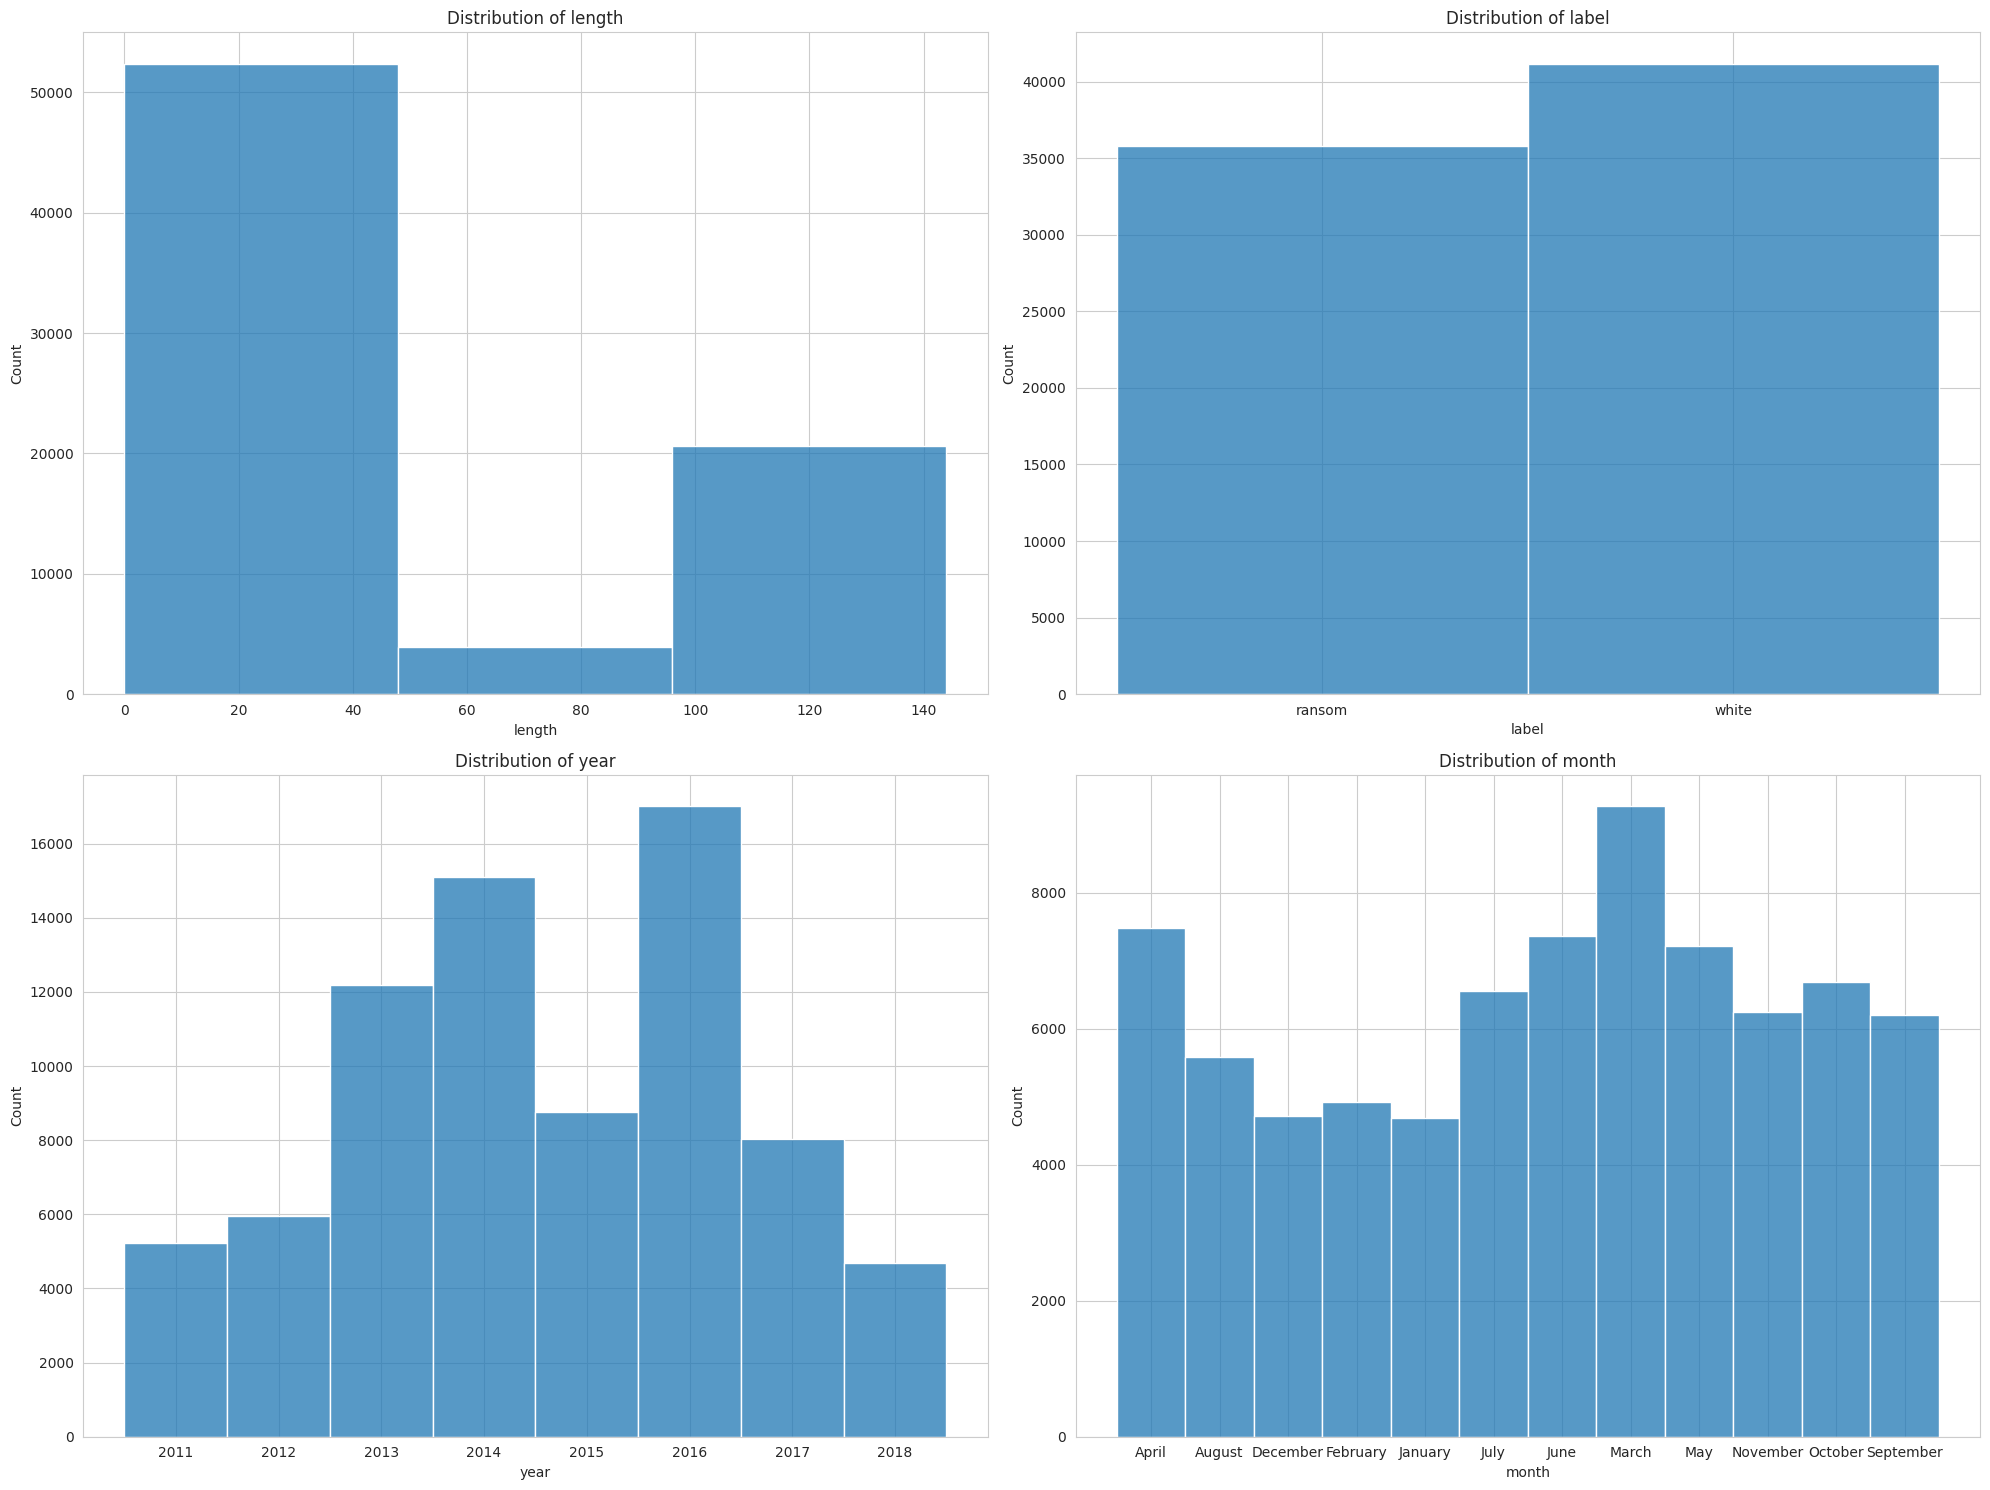

In [94]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Adjusting the subplot layout to accommodate the updated number of variables
fig, ax = plt.subplots(2, 2, figsize=(20, 15))  # Adjusted to 3x3


categorical_columns = ['length','label', 'year', 'month']
for i, column in enumerate(categorical_columns, start=0):  # Start from the third plot, order=range(1, 13))
    sns.histplot(bit[column], bins=3, ax=ax[i//2, i%2], kde=False, orientation='vertical')
    ax[i//2, i%2].set_title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

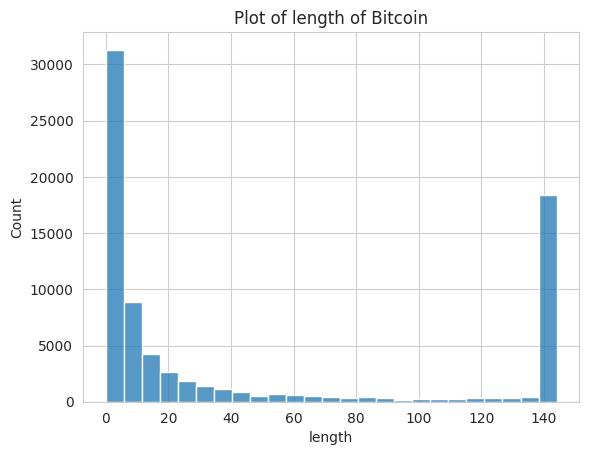

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(bit['length'], kde=False)
plt.title("Plot of length of Bitcoin")
plt.xlabel("length")
plt.show()

In [100]:
from sklearn.model_selection import train_test_split

X = bit.drop('label_white', axis=1)
y = bit['label_white']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [101]:
X_train.shape

(53844, 24)

In [102]:
X_test.shape

(23076, 24)

# Classical Models

## Decision Trees

In [103]:
from sklearn.tree import DecisionTreeClassifier
model_dt = DecisionTreeClassifier(random_state=1).fit(X_train, y_train)
from sklearn.metrics import classification_report
print(f"Performance on TEST\n*******************\n{classification_report(y_test, model_dt.predict(X_test))}")
print(f"Performance on TRAIN\n********************\n{classification_report(y_train, model_dt.predict(X_train))}")

Performance on TEST
*******************
              precision    recall  f1-score   support

       False       0.82      0.82      0.82     10814
        True       0.84      0.84      0.84     12262

    accuracy                           0.83     23076
   macro avg       0.83      0.83      0.83     23076
weighted avg       0.83      0.83      0.83     23076

Performance on TRAIN
********************
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     24949
        True       1.00      1.00      1.00     28895

    accuracy                           1.00     53844
   macro avg       1.00      1.00      1.00     53844
weighted avg       1.00      1.00      1.00     53844



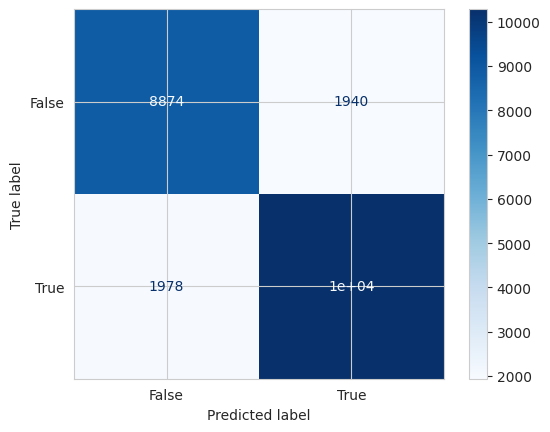

In [104]:
from sklearn.metrics import ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay.from_estimator(model_dt, X_test, y_test,cmap=plt.cm.Blues,normalize=None)

## Logistic Regression

In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# fit the LG model -- random_state is used to shuffle the bit; max_iter is max # of iterations for solver to converge (default is 100)
model_lr = LogisticRegression(random_state=1, max_iter=1000,solver = 'saga').fit(X_train, y_train)
# print the report
print(f"Performance on TEST\n*******************\n{classification_report(y_test, model_lr.predict(X_test))}")
print(f"Performance on TRAIN\n********************\n{classification_report(y_train, model_lr.predict(X_train))}")

Performance on TEST
*******************
              precision    recall  f1-score   support

       False       0.56      0.57      0.57     10814
        True       0.61      0.60      0.61     12262

    accuracy                           0.59     23076
   macro avg       0.59      0.59      0.59     23076
weighted avg       0.59      0.59      0.59     23076

Performance on TRAIN
********************
              precision    recall  f1-score   support

       False       0.55      0.58      0.57     24949
        True       0.62      0.60      0.61     28895

    accuracy                           0.59     53844
   macro avg       0.59      0.59      0.59     53844
weighted avg       0.59      0.59      0.59     53844



/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


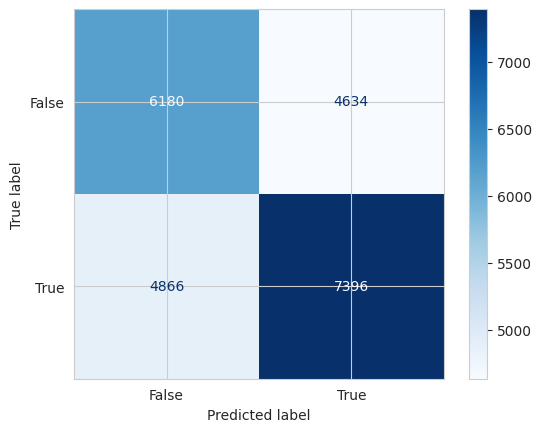

In [106]:
cm_display = ConfusionMatrixDisplay.from_estimator(model_lr, X_test, y_test,cmap=plt.cm.Blues,normalize=None)

## KNN

In [107]:
from sklearn.neighbors import KNeighborsClassifier

# instantiate the model
knn = KNeighborsClassifier(n_neighbors=3)

# fit the model to the training set
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [108]:
### Check the accuracy on the test bit
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

accuracy_test=accuracy_score(y_test, knn.predict(X_test))
print('Accuracy of knn on test bit is : {:.2}'.format(accuracy_test))

# Check accuracy on the training bit
accuracy_train=accuracy_score(y_train, knn.predict(X_train))
print('Accuracy of knn on train bit is : {:.2}'.format(accuracy_train))

Accuracy of knn on test data is : 0.73
Accuracy of knn on train data is : 0.85


In [109]:
y_pred = knn.predict(X_test)
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"f1_score: {f1_score(y_test, y_pred)}")

Recall: 0.7194584896427989
Precision: 0.756085018854988
f1_score: 0.7373171750940243


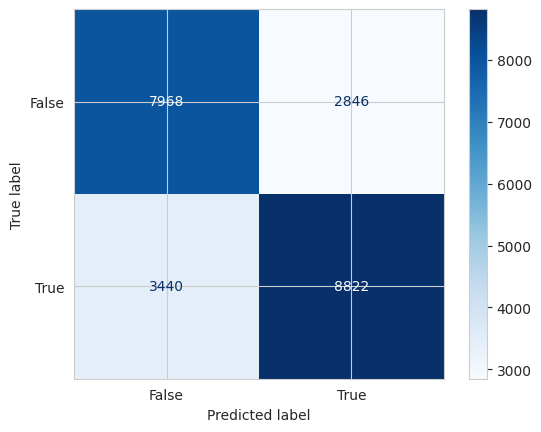

In [110]:
cm_display = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test,cmap=plt.cm.Blues,normalize=None)

## Random Forest (current issues)

In [24]:
"""from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier()
param_grid = {
   "n_estimators": np.arange(start=10, stop=100, step=2),
   "max_depth": np.arange(start=2, stop=20),
   "min_samples_leaf": np.arange(start=1, stop=5),
   "class_weight": [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}],
}

gscv = GridSearchCV(model, param_grid, cv=5, n_jobs=8, scoring="recall", )
gscv.fit(X_train, y_train)
gscv.best_params_"""

'from sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import GridSearchCV\n\nmodel = RandomForestClassifier()\nparam_grid = {\n   "n_estimators": np.arange(start=10, stop=100, step=2),\n   "max_depth": np.arange(start=2, stop=20),\n   "min_samples_leaf": np.arange(start=1, stop=5),\n   "class_weight": [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}],\n}\n\ngscv = GridSearchCV(model, param_grid, cv=5, n_jobs=8, scoring="recall", )\ngscv.fit(X_train, y_train)\ngscv.best_params_'

In [25]:
#from sklearn.metrics import classification_report
#print(f"Performance on TEST\n*******************\n{classification_report(y_test, model.predict(X_test))}")
#print(f"Performance on TRAIN\n********************\n{classification_report(y_train, model.predict(X_train))}")

## Naive Bayes

In [111]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [112]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.56      0.92      0.70     10814
        True       0.84      0.36      0.51     12262

    accuracy                           0.62     23076
   macro avg       0.70      0.64      0.60     23076
weighted avg       0.71      0.62      0.60     23076



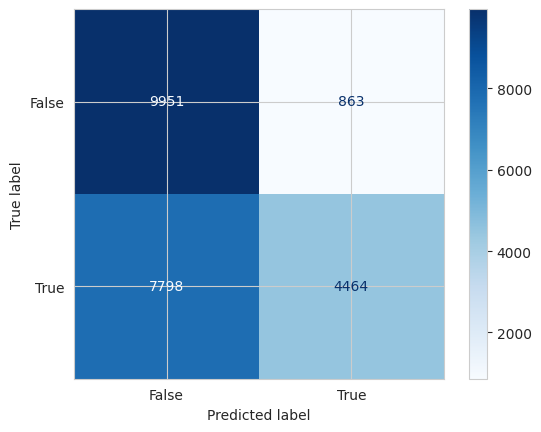

In [113]:
cm_display = ConfusionMatrixDisplay.from_estimator(gnb, X_test, y_test,cmap=plt.cm.Blues,normalize=None)

# Advanced Classical Algorithims

## Support Vector Machine (SVC)

In [114]:
from sklearn.svm import LinearSVC, SVC
model_SVC = SVC()

In [115]:
y_pred = model_SVC.fit(X_train,y_train).predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.58      0.19      0.29     10814
        True       0.55      0.88      0.68     12262

    accuracy                           0.56     23076
   macro avg       0.57      0.54      0.48     23076
weighted avg       0.57      0.56      0.50     23076



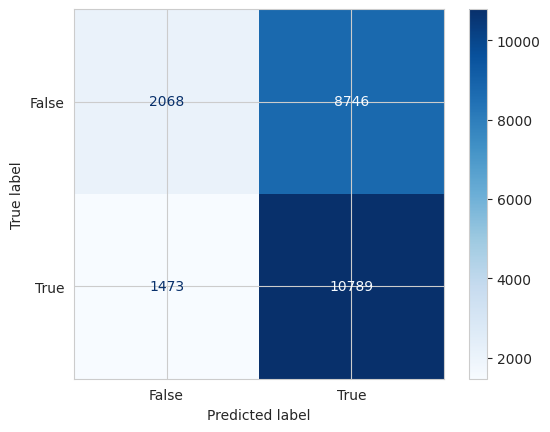

In [116]:
cm_display = ConfusionMatrixDisplay.from_estimator(model_SVC, X_test, y_test,cmap=plt.cm.Blues,normalize=None)

## Linear Support Vector Machine (LinearSVC)

In [117]:
model_LinearSVC = LinearSVC()

In [118]:
y_pred = model_LinearSVC.fit(X_train,y_train).predict(X_test)
print(classification_report(y_test,y_pred))

/usr/local/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

       False       0.63      0.82      0.72     10814
        True       0.79      0.58      0.67     12262

    accuracy                           0.69     23076
   macro avg       0.71      0.70      0.69     23076
weighted avg       0.71      0.69      0.69     23076



/usr/local/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


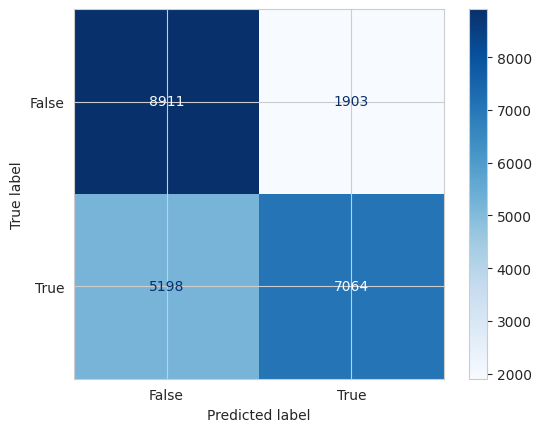

In [119]:
cm_display = ConfusionMatrixDisplay.from_estimator(model_LinearSVC, X_test, y_test,cmap=plt.cm.Blues,normalize=None)

# TabTranformer (Transformer Model Capable of Processing Tabular bit)

### Creating Testing, Training & Validation bit

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train2, X_valid, y_train2, y_valid = train_test_split(X,y, test_size = 0.2, random_state = 1)
print(f'Test Shape: {X_test.shape}\nTrain Shape: {X_train.shape}')
print(f'Validation Shape: {X_valid.shape}\nTrain Shape: {X_train2.shape}')

Test Shape: (23076, 24)
Train Shape: (53844, 24)
Validation Shape: (15384, 24)
Train Shape: (61536, 24)


### Hyper-Parameter Configuration

In [165]:
import keras
from keras import layers
from keras import ops

import math
from tensorflow import bit as tf_bit
from functools import partial

In [47]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, LayerNormalization, Flatten, MultiHeadAttention
from tensorflow.keras.models import Model

# Separate features (X) and target variable (y)
X = bit.drop(columns=['label_white'], axis=1)
y = bit['label_white']

# Split data into training and testing sets
X_train_num, X_test_num, X_train_cat, X_test_cat, y_train, y_test = \
    train_test_split(X_numerical, X_categorical, y, test_size=0.2, random_state=42)

# Define input layers for numerical and categorical data
num_inputs = Input(shape=(X_train_num.shape[1],))
cat_inputs = Input(shape=(X_train_cat.shape[1],))

# Perform operations on categorical variables
cat_dense = Dense(128, activation='relu')(cat_inputs)
cat_norm = LayerNormalization()(cat_dense)
cat_attention = MultiHeadAttention(num_heads=8, key_dim=64)(value=cat_norm,query=cat_norm,key=cat_norm)
cat_dropout = Dropout(0.1)(cat_attention)
cat_norm_2 = LayerNormalization()(cat_dropout)
cat_flatten = Flatten()(cat_norm_2)

# Concatenate numerical and processed categorical inputs
combined_inputs = Concatenate()([num_inputs, cat_flatten])
#combined_inputs = Concatenate()([num_inputs, cat_inputs])

# Dense layers for classification
x = Dense(256, activation='relu')(combined_inputs)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Use 'sigmoid' for binary classification

# Create the model using the Functional API
model = Model(inputs=[num_inputs, cat_inputs], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# Train the model
model.fit([X_train_num, X_train_cat], y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate([X_test_num, X_test_cat], y_test)
print(f'Test Accuracy: {test_accuracy}')

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_55      │ (None, 36)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_62 (Dense)    │ (None, 128)       │      4,736 │ input_layer_55[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense_62[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128)       │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 128)       │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dropout_31[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_54      │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 130)       │          0 │ input_layer_54[0… │
│ (Concatenate)       │                   │            │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_63 (Dense)    │ (None, 256)       │     33,536 │ concatenate_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 256)       │          0 │ dense_63[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 128)       │     32,896 │ dropout_32[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_65 (Dense)    │ (None, 1)         │        129 │ dense_64[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 335,617 (1.28 MB)

 Trainable params: 335,617 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


IndexError: Exception encountered when calling Softmax.call().

[1mtuple index out of range[0m

Arguments received by Softmax.call():
  • inputs=tf.Tensor(shape=(None, 8), dtype=float32)
  • mask=None